**IMPORTING NECESSARY LIBRARIES**

TODO: inference time of neural network scores, input/output interface (check my code-probably doesnt work properly), take recall, f1 score into account

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import tensorflow as tf
from tensorflow import keras

uploaded=files.upload()
data = pd.read_csv('Spam Email raw text for NLP.csv')

Saving Spam Email raw text for NLP.csv to Spam Email raw text for NLP.csv


**PRESENTING DATA**

Let us start by checking what the data looks like before any preprocessing.

In [ ]:
data.head

<bound method NDFrame.head of       CATEGORY                                            MESSAGE  \
0            1  Dear Homeowner,\n\n \n\nInterest Rates are at ...   
1            1  ATTENTION: This is a MUST for ALL Computer Use...   
2            1  This is a multi-part message in MIME format.\n...   
3            1  IMPORTANT INFORMATION:\n\n\n\nThe new domain n...   
4            1  This is the bottom line.  If you can GIVE AWAY...   
...        ...                                                ...   
5791         0  I'm one of the 30,000 but it's not working ver...   
5792         0  Damien Morton quoted:\n\n>W3C approves HTML 4 ...   
5793         0  On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...   
5794         0  Once upon a time, Manfred wrote :\n\n\n\n> I w...   
5795         0  If you run Pick, and then use the "New FTOC" b...   

                                   FILE_NAME  
0     00249.5f45607c1bffe89f60ba1ec9f878039a  
1     00373.ebe8670ac56b04125c25100a36ab0510  


Now, let's see what proportion of our data consists of spam and non-spam emails.

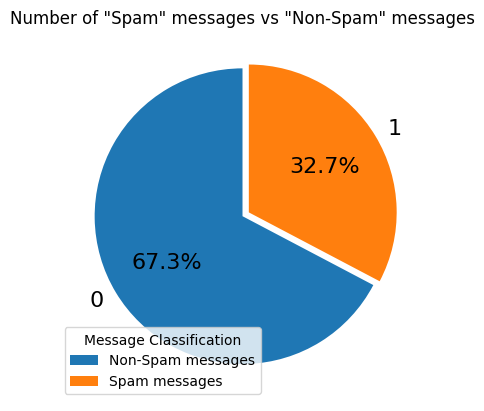

In [ ]:
# pie chart timeeeeeeeee

# Count the number of '1' and '0' messages
message_counts = data['CATEGORY'].value_counts()

# Create a pie plot
plt.pie(message_counts.values, labels=message_counts.index, textprops={'fontsize':16}, startangle=90, autopct='%1.1f%%',
        explode=[0,0.05])

# Add labels and title
plt.title('Number of "Spam" messages vs "Non-Spam" messages')
plt.legend(title='Message Classification', labels=['Non-Spam messages', 'Spam messages'])

# Show the plot
plt.show()

In [ ]:
message_counts

0    3900
1    1896
Name: CATEGORY, dtype: int64

**DATA PREPROCESSING**

First, we define a function that will clean our data for us.

> Removing HTML tags, non-alphanumeric characters

> Turn all words into lowercase

For now we will ignore all punctuation altogether, since we believe that there is sufficient information in the words used.

Afterwards, we will lemmatize words as it reduces vocabulary size and generalizes words to their "true" meaning.

In [ ]:
import re
from bs4 import BeautifulSoup
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

lemmatizer = WordNetLemmatizer()
processed_text = []

def clean(message):
    # remove HTML tags
    soup = BeautifulSoup(message, "html.parser")
    cleaned_text = soup.get_text()
    return cleaned_text

def clean2(cleaned_text):
  # remove punctuation and non-alphanumeric characters
    pattern = r'[^a-zA-Z\s]'
    cleaned_text = re.sub(pattern, '', cleaned_text)

    # convert lowercase and splitting
    words = cleaned_text.lower().split()
    return words

# applies the functions to a specified column
data['MESSAGE'] = data['MESSAGE'].apply(clean)
data['OG_messages']=data['MESSAGE']
data['MESSAGE'] = data['MESSAGE'].apply(clean2)

for i in tqdm(range(0, len(data))):
    dirty_text = data['MESSAGE'][i]
    dirty_text = [word for word in dirty_text if not word in set(stopwords.words('english'))] # remove stopwords
    dirty_text = [lemmatizer.lemmatize(word) for word in dirty_text] # lemmatize
    processed_text.append(dirty_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-5-1f0d0ba0d64c>:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, "html.parser")
<ipython-input-5-1f0d0ba0d64c>:15: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, "html.parser")
100%|██████████| 5796/5796 [02:22<00:00, 40.67it/s]


Let's check if the cleaning worked.

In [ ]:
data

**FURTHER CLEANING**

We now want to standardize the length of our emails. We do this by dropping emails that are outside a certain range.

> For the range, we decided on using 100 words as our token length, since the majority of emails are of length >= 100

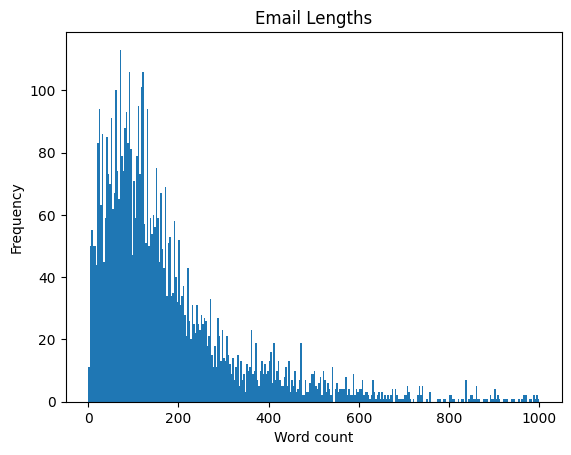

In [ ]:
# get the word lengths of each email and store it in a list
email_lens = []
for index, row in data.iterrows():
  email_lens.append(len(data.loc[index, "MESSAGE"]))

# for the sake of simplicity, add these values as a column to the df
data["email_lens"] = email_lens
plt.hist(email_lens, bins=300, range=(0, 1000)) # improves visibility of plot
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.title("Email Lengths")
plt.show()

In [ ]:
token_len = 100 # number of words
# only select rows where email_len >= token_len
data = data[data["email_lens"] >= token_len] # drops all other rows that do not satisfy the condition

proc_emails = []
for index, row in data.iterrows():

  # truncates elements 100+, adds those words to the filtered_emails list
  words = data.loc[index, "MESSAGE"][:token_len]
  proc_emails.append(words)

# and add the list of words back into df["proc_overview"]
data["proc_emails"] = proc_emails

# let's see how many observations we have remaining
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3655 entries, 1 to 5795
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CATEGORY     3655 non-null   int64 
 1   MESSAGE      3655 non-null   object
 2   FILE_NAME    3655 non-null   object
 3   OG_messages  3655 non-null   object
 4   email_lens   3655 non-null   int64 
 5   proc_emails  3655 non-null   object
dtypes: int64(2), object(4)
memory usage: 328.9+ KB


<ipython-input-7-1d65d9a84acf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["proc_emails"] = proc_emails


Creating our vocabulary and finding out how long it is.

In [ ]:
words = []
for index, row in data.iterrows():
  words.extend(row["proc_emails"])

# sort and remove duplicates to get vocabulary
unique_words = sorted(list(set(words)))

vocab_len = len(unique_words)
print("There are " + str(vocab_len) + " unique words.")

There are 26729 unique words.


**ENCODING**

We want to first try encoding using the method we learned in our assignments, but if we have time we will look into autoencoders that preserve word-order, and sentence structure (like BERT).

As for the method we learned in our assignments, we first define a function to encode for us.

Then, we use this function to encode our filtered/processed emails that have been standardized (in terms of token length).

In [ ]:
def encode_labels(label, unique_labels):
  out = np.zeros(len(unique_labels))
  if isinstance(label, str): # checks if input label is a string
      if label in unique_labels:
        out[unique_labels.index(label)] = 1

  elif isinstance(label, list): # checks if input label is a list
      for word in label:
          if word in unique_labels:
              out[unique_labels.index(word)] += 1

  return out

In [ ]:
encoded_emails = []
for index, row in tqdm(data.iterrows(), total=len(data)):
    sentence_encode = encode_labels(data["proc_emails"][index], unique_words)
    encoded_emails.append(sentence_encode)

data["encodingsA"] = encoded_emails

100%|██████████| 3655/3655 [04:09<00:00, 14.64it/s]
<ipython-input-11-983afc276dba>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encodingsA"] = encoded_emails


Let's check if our encodings generated properly.

In [ ]:
data['encodingsA']

1       [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
5788    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5789    [5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5790    [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5794    [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5795    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: encodingsA, Length: 3655, dtype: object

In [ ]:
print(unique_words)

['a', 'aa', 'aaaa', 'aaaaaaaaaa', 'aaaacbbfddfddcfccdbbdcabddebcedcc', 'aaaag', 'aaaambacbabdabfbccbbabbcbeabacbfcea', 'aaaazaaaaaeaawmdapaascpaaeaaqaaaaaaaaaaaaaaagaiabkbkaaaaaaaaaaaaaaaaaaa', 'aaacbfbcaacefcbabccfbcd', 'aaaoxaaadsqblssogwaajjrefuenrsqtgdlpvstwctvbegyrjmjqzgehbnnjji', 'aabaabhaceadbdc', 'aabbf', 'aabcfbde', 'aabfccaccdbfecdabddbdbacdbecccbdaacffontecfont', 'aacaadcacebbaba', 'aacdbbddbacdcfdbcaacfbaacbacfdbabde', 'aacdbcebcaababccdcbcbcbfaababa', 'aacddccfaaddccdbcafddccfbfceabb', 'aacebdaccfbcfeaba', 'aadacaeaba', 'aadacfbbbdcabdaba', 'aaeaaaaaaaaaaaaaaaaaaaaaoejjtqptcljlcsdxrpbaaaaaeabiaaaaaqacaegaaaab', 'aaiqklnbayrlggrxvymfsiexpzhawniefuzxlaaaaaaqaaaaeoejjtqqzekzyieds', 'aalib', 'aaliyah', 'aall', 'aambabfbccbbabbcaba', 'aaron', 'aaronsen', 'aarp', 'aas', 'aaxine', 'aayahoocom', 'ab', 'ababbu', 'abacbfceadcbddaadcbddbcafddbabbcb', 'abacha', 'abachaafricamailnet', 'abachamailafricacom', 'abaeab', 'abaeabbiabha', 'abandon', 'abandoned', 'abatement', 'abbiabhacea', '

From the encodings we can see, stopwords were not properly removed. We will look further into why this happens.

Also, there appears to be many words that aren't actually *words*, just gargbles of letters. We'll look into autoencoders that handle these cases appropriately for our use case.

We don't necessarily want to run a spellchecker on our words, but maybe there exists an elegant solution to words that do not "exist".

**DO WE?**

**SPLITTING DATA**

In [ ]:
# Split the data

from sklearn.model_selection import train_test_split

# Change encodingsA from an object to an array
X = np.array(data['encodingsA'].to_numpy())
X = np.vstack(X)
y = data['CATEGORY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Logistic Regression**

probably still doesnt work, always the same result?
- It seems like it works. See the code below, the testing score decreases if we limit the amount of observations in the training set.



In [ ]:
from sklearn.linear_model import LogisticRegression
from time import perf_counter
modelLR = LogisticRegression(max_iter=200)

start = perf_counter()
modelLR = modelLR.fit(X_train,y_train)
end = perf_counter()
fit_time_LR = end-start

start = perf_counter()
train_score_LR = modelLR.score(X_train, y_train)
end = perf_counter()
train_score_time_LR = end-start

start = perf_counter()
test_score_LR = modelLR.score(X_test,y_test)
end = perf_counter()
test_score_time_LR = end-start

print("Training score:", train_score_LR)
print("Testing score: ", test_score_LR)

Training score: 1.0
Testing score:  0.9849521203830369


In [ ]:
# See where the model was wrong and output a random message.
import random

# Predict labels for the training data
y_pred = modelLR.predict(X_test)
incorrect_indices = [index for index, (test, pred) in enumerate(zip(y_test, y_pred)) if test != pred]


random_element = random.choice(incorrect_indices)
random_message_incorrect = X_test[random_element]
if y_pred[random_element] == 0:
    print("Spam was classified as not spam.")
else:
    print("Not spam was classified as spam.")

print("Incorrect prediction indices: \n", incorrect_indices, "\n")

print("First 1000 characters of associated incorrect prediction message:\n","".join(data["OG_messages"][random_element])[:1000])


Not spam was classified as spam.
Incorrect prediction indices: 
 [30, 63, 88, 176, 225, 313, 367, 421, 450, 529, 645] 

First 1000 characters of associated incorrect prediction message:
 --===_SecAtt_000_1fheucnqggtggp

Content-Type: text/plain; charset="us-ascii"

Content-Transfer-Encoding: quoted-printable



URGENT PRIVATE & EXTREMELY CONFIDENTIAL







Dear =2C



With profound interest and in utmost confidence=2C I am

soliciting your immediate assistance or co-operation

as to enable us round up an opportunity within my

capability as a result of the death of one of our

contractor =28Beneficiary=29=2E You should not be surprised

as to how I got your contact=2C you were highly

recommended to me with the believe that you are

competent=2C reliable=2C Trustworthy and confident=2E



I am  Dr=2E Bello Ahmed=2C Chief Auditor=2C Special Project

and Foreign Contract Regularization and Disbursement=2C

in the Office of the Auditor General of the Federation

of Federal Republic of Ni

**DECISION TREE**

In [ ]:
from sklearn import tree

train_acc_mean, train_acc_std = [], [] # to store the training accuracies
test_acc_mean, test_acc_std = [], []   # to store the testing accuracies

for d in tqdm(range(4,13)): # loop over tree depths
    train_perfs = [] # store interem train scores
    test_perfs = []  # store interem test scores
    for n in tqdm(range(10)):   # loop over random initializations
        tree_model = tree.DecisionTreeClassifier(max_depth=d) # init new model
        tree_model = tree_model.fit(X_train, y_train) # train model
        train_perfs.append(tree_model.score(X_train, y_train)) # store interem values
        test_perfs.append(tree_model.score(X_test,y_test))

    # append mean and std scores to appropriate lists
    train_acc_mean.append(np.mean(train_perfs))
    train_acc_std.append(np.std(train_perfs))
    test_acc_mean.append(np.mean(test_perfs))
    test_acc_std.append(np.std(test_perfs))

accuracy_DT = test_acc_mean

100%|██████████| 9/9 [06:48<00:00, 45.37s/it]


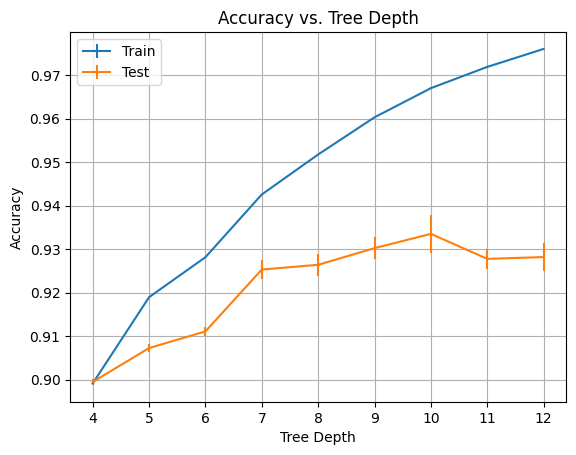

In [ ]:
d=range(4,13)
plt.errorbar(d, train_acc_mean, yerr=train_acc_std, label="Train")
plt.errorbar(d, test_acc_mean, yerr=test_acc_std, label="Test")
plt.title("Accuracy vs. Tree Depth")
plt.ylabel("Accuracy")
plt.xlabel("Tree Depth")
plt.grid()
plt.legend()
plt.show()

**Decision tree model with the most appropriate depth**

In [ ]:
modelDT=tree.DecisionTreeClassifier(max_depth=10)
start = perf_counter()
modelDT = modelDT.fit(X_train,y_train)
end = perf_counter()
fit_time_DT = end-start

start = perf_counter()
train_score_DT = modelDT.score(X_train, y_train)
end = perf_counter()
train_score_time_DT = end-start

start = perf_counter()
test_score_DT = modelDT.score(X_test,y_test)
end = perf_counter()
test_score_time_DT = end-start

print("Training score:", train_score_DT)
print("Testing score: ", test_score_DT)

Training score: 0.9671682626538988
Testing score:  0.9343365253077975


**NEURAL NETWORK**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
X_test.shape

(731, 26729)

In [ ]:
import keras.backend as K

# Build the model
modelNN = keras.Sequential([
    keras.layers.Dense(64, input_shape=(26729,), activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

#f1 score function
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

# Compile the model
modelNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

# Train the model: choose batch size and number of epochs
start = perf_counter()
history = modelNN.fit(X_train, y_train, batch_size=10, epochs=20, validation_split=0.2)
end = perf_counter()
fit_time_NN = end-start

# Evaluate the model
test_loss, test_acc, test_f1 = modelNN.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test F1 score:', test_f1)

accuracy_NN = test_acc

Epoch 1/20
234/234 [==============================] - 4s 8ms/step - loss: 0.1538 - accuracy: 0.9354 - f1_score: 0.8529 - val_loss: 0.0681 - val_accuracy: 0.9778 - val_f1_score: 0.9245
Epoch 2/20
234/234 [==============================] - 2s 9ms/step - loss: 0.0081 - accuracy: 0.9974 - f1_score: 0.9879 - val_loss: 0.0721 - val_accuracy: 0.9795 - val_f1_score: 0.9260
Epoch 3/20
234/234 [==============================] - 2s 7ms/step - loss: 7.1719e-04 - accuracy: 1.0000 - f1_score: 0.9957 - val_loss: 0.0721 - val_accuracy: 0.9846 - val_f1_score: 0.9464
Epoch 4/20
234/234 [==============================] - 1s 5ms/step - loss: 1.6328e-04 - accuracy: 1.0000 - f1_score: 0.9957 - val_loss: 0.0739 - val_accuracy: 0.9846 - val_f1_score: 0.9464
Epoch 5/20
234/234 [==============================] - 1s 5ms/step - loss: 5.6270e-05 - accuracy: 1.0000 - f1_score: 0.9786 - val_loss: 0.0753 - val_accuracy: 0.9846 - val_f1_score: 0.9464
Epoch 6/20
234/234 [==============================] - 1s 5ms/step - 

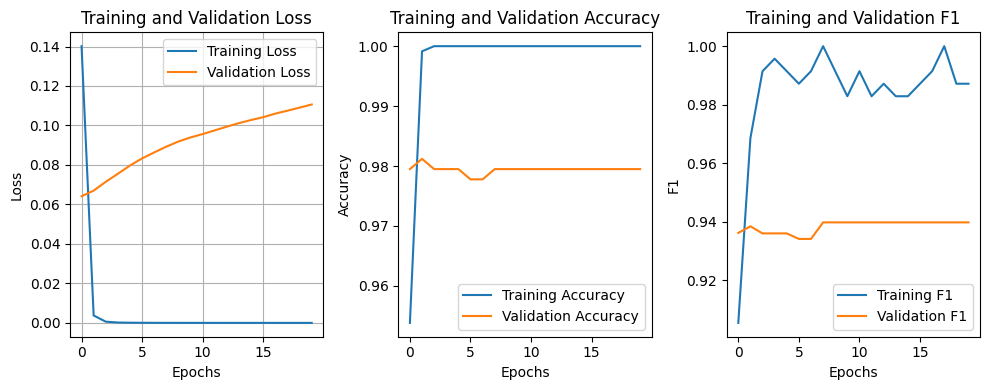

In [ ]:
# Get the training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the training and validation accuracy values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_f1=history.history['f1_score']
val_f1=history.history['val_f1_score']

# Plot the training and validation losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()

# Plot the training and validation accuracies
plt.subplot(1, 3, 2)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot the training and validation accuracies
plt.subplot(1, 3, 3)
plt.plot(range(len(train_f1)), train_f1, label='Training F1')
plt.plot(range(len(val_f1)), val_f1, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.title('Training and Validation F1')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#input
input_mail=input("Enter the mail you want to predict: ")
#clean
clean(input_mail)
clean2(input_mail)
#encode
mail_encoded = encode_labels(input_mail, unique_words)

reshaped_mail_encoded = mail_encoded.reshape(1, -1)
print(reshaped_mail_encoded.shape)
print(modelLR.predict(reshaped_mail_encoded))

**COMPARISON OF THE MODELS**

In [ ]:
# Accuracy of Neural Netwrok
print("Accuracy of Neural Netwrok")
print(accuracy_NN)
print("")

# Accuracy of Decision Tree
print("Accuracy of Decision Tree")
print(np.mean(accuracy_DT))
print("")

# Accuracy of Logistic Regression
print("Accuracy of Logistric Regression")
print(test_score_LR)
print("")

Accuracy of Neural Netwrok
0.9835841059684753

Accuracy of Decision Tree
0.9210214318285453

Accuracy of Logistric Regression
0.9849521203830369



[0.31055472595977685, 0.30375040227290556, 0.30375040227290556]


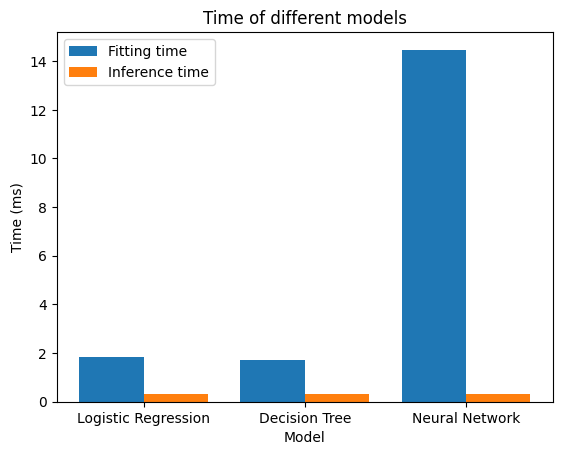

In [ ]:
model_names=['Logistic Regression', 'Decision Tree','Neural Network']
fig, ax = plt.subplots()
x = np.arange(len(model_names))

fit_times=[fit_time_LR,fit_time_DT,fit_time_NN]
fit_times = [1000*fit_time / len(X_train) for fit_time in fit_times]
#NO NN INF TIME!
inf_times=[train_score_time_LR+test_score_LR,train_score_time_DT+test_score_DT,train_score_time_DT+test_score_DT]
inf_times = [1000*inf_time / (len(X_test)+len(X_train)) for inf_time in inf_times]
print(inf_times)

bar2 = ax.bar(x-0.2,fit_times,0.4,label='Fitting time') # fit times: don't forget labels
bar1 = ax.bar(x+0.2,inf_times,0.4,label='Inference time') # inference times
ax.set_xticks(x)
ax.set_xlabel('Model')
ax.set_ylabel('Time (ms)')
ax.set_title('Time of different models')
ax.set_xticklabels(model_names)
ax.legend()